In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Data

/content/drive/.shortcut-targets-by-id/1OCqWIB1HkFVJkMAo4e6tMdDWvRFnQFMm/Data


## REQUIRED LIBRARIES

In [ ]:
import os
import keras
import string
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
from numpy import array
from pickle import load, dump
from collections import Counter
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu

import sys, time, warnings
warnings.filterwarnings("ignore")
import re

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.applications.inception_v3 import preprocess_input

In [ ]:
from keras.utils.vis_utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [ ]:
from scipy.spatial import distance
from scipy.ndimage.filters import convolve
from scipy.sparse import diags, csr_matrix
from scipy.sparse.linalg import spsolve

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical,plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import GRU
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.applications.resnet_v2 import ResNet152V2, preprocess_input

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.callbacks import ModelCheckpoint

# Preparation of Image for the Input

## REDUCE BRIGHTNESS OF IMAGE

In [ ]:
#Reduce Brightness of the Image
from PIL import Image
def boundedPixelValue(color, brightnessFactor):
    scaledValue = float(color * (1 + brightnessFactor))
    if scaledValue < 0:
        return 0
    elif scaledValue > 255:
        return 255
    return int(scaledValue)
def reduce_brightness(im):
    out = Image.new('RGB', im.size, 0xffffff)
    brightnessFactor = float(-0.9)
    width, height = im.size
    for x in range(width):
        for y in range(height):
            r,g,b = im.getpixel((x,y))
            updatedR = boundedPixelValue(r, brightnessFactor)
            updatedG = boundedPixelValue(g, brightnessFactor)
            updatedB = boundedPixelValue(b, brightnessFactor)
            out.putpixel((x,y), (updatedR, updatedG, updatedB))
    return out

In [ ]:
#CHECK FOR THE BRIGHTNESS OF IMAGE
def brightness( im ):
   stat = ImageStat.Stat(im)
   gs = (math.sqrt(0.241*(r**2) + 0.691*(g**2) + 0.068*(b**2)) 
         for r,g,b in im.getdata())
   return sum(gs)/stat.count[0]

## ENHANCING IMAGE

In [ ]:
def get_sparse_neighbor(p: int, n: int, m: int):
    """
    Returns a dictionnary, where the keys are index of 4-neighbor of `p` in the sparse matrix,
       and values are tuples (i, j, x), where `i`, `j` are index of neighbor in the normal matrix,
       and x is the direction of neighbor.
    Arguments:
        p {int} -- index in the sparse matrix.
        n {int} -- number of rows in the original matrix (non sparse).
        m {int} -- number of columns in the original matrix.
    Returns:
        dict -- dictionnary containing indices of 4-neighbors of `p`.
    """
    i, j = p // m, p % m
    d = {}
    if i - 1 >= 0:
        d[(i - 1) * m + j] = (i - 1, j, 0)
    if i + 1 < n:
        d[(i + 1) * m + j] = (i + 1, j, 0)
    if j - 1 >= 0:
        d[i * m + j - 1] = (i, j - 1, 1)
    if j + 1 < m:
        d[i * m + j + 1] = (i, j + 1, 1)
    return d

In [ ]:
def create_spacial_affinity_kernel(spatial_sigma: float, size: int = 15):
    """Create a kernel (`size` * `size` matrix) that will be used to compute the he spatial affinity based Gaussian weights.
    Arguments:
        spatial_sigma {float} -- Spatial standard deviation.
    Keyword Arguments:
        size {int} -- size of the kernel. (default: {15})
    Returns:
        np.ndarray - `size` * `size` kernel
    """
    kernel = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            kernel[i, j] = np.exp(-0.5 * (distance.euclidean((i, j),
                                  (size // 2, size // 2)) ** 2) / (spatial_sigma ** 2))
    return kernel

In [ ]:
def compute_smoothness_weights(L: np.ndarray, x: int, kernel: np.ndarray, eps: float = 1e-3):
    """Compute the smoothness weights used in refining the illumination map optimization problem.
    Arguments:
        L {np.ndarray} -- the initial illumination map to be refined.
        x {int} -- the direction of the weights. Can either be x=1 for horizontal or x=0 for vertical.
        kernel {np.ndarray} -- spatial affinity matrix
    Keyword Arguments:
        eps {float} -- small constant to avoid computation instability. (default: {1e-3})
    Returns:
        np.ndarray - smoothness weights according to direction x. same dimension as `L`.
    """
    Lp = cv2.Sobel(L, cv2.CV_64F, int(x == 1), int(x == 0), ksize=1) # Sobel -> Edge Detection
    T = convolve(np.ones_like(L), kernel, mode='constant')
    T = T / (np.abs(convolve(Lp, kernel, mode='constant')) + eps) # adds padding 
    return T / (np.abs(Lp) + eps)

In [ ]:
def refine_illumination_map_linear(L: np.ndarray, gamma: float, lambda_: float, kernel: np.ndarray, eps: float = 1e-3):
    """Refine the illumination map based on the optimization problem described in the two papers.
       This function use the sped-up solver presented in the LIME paper.
    Arguments:
        L {np.ndarray} -- the illumination map to be refined.
        gamma {float} -- gamma correction factor.
        lambda_ {float} -- coefficient to balance the terms in the optimization problem.
        kernel {np.ndarray} -- spatial affinity matrix.
    Keyword Arguments:
        eps {float} -- small constant to avoid computation instability (default: {1e-3}).
    Returns:
        np.ndarray -- refined illumination map. same shape as `L`.
    """
    # compute smoothness weights
    wx = compute_smoothness_weights(L, x=1, kernel=kernel, eps=eps)
    wy = compute_smoothness_weights(L, x=0, kernel=kernel, eps=eps)
    n, m = L.shape
    L_1d = L.copy().flatten()
    # compute the five-point spatially inhomogeneous Laplacian matrix
    row, column, data = [], [], []
    for p in range(n * m):
        diag = 0
        for q, (k, l, x) in get_sparse_neighbor(p, n, m).items():
            weight = wx[k, l] if x else wy[k, l]
            row.append(p)
            column.append(q)
            data.append(-weight)
            diag += weight
        row.append(p)
        column.append(p)
        data.append(diag)
    F = csr_matrix((data, (row, column)), shape=(n * m, n * m))
    # solve the linear system
    Id = diags([np.ones(n * m)], [0])
    A = Id + lambda_ * F
    L_refined = spsolve(csr_matrix(A), L_1d, permc_spec=None,
                        use_umfpack=True).reshape((n, m))
    # gamma correction
    L_refined = np.clip(L_refined, eps, 1) ** gamma

    return L_refined

In [ ]:
def correct_underexposure(im: np.ndarray, gamma: float, lambda_: float, kernel: np.ndarray, eps: float = 1e-3):
    """correct underexposudness using the retinex based algorithm presented in LIME paper.
    Arguments:
        im {np.ndarray} -- input image to be corrected.
        gamma {float} -- gamma correction factor.
        lambda_ {float} -- coefficient to balance the terms in the optimization problem.
        kernel {np.ndarray} -- spatial affinity matrix.
    Keyword Arguments:
        eps {float} -- small constant to avoid computation instability (default: {1e-3})
    Returns:
        np.ndarray -- image underexposudness corrected. same shape as `im`.
    """

    # first estimation of the illumination map
    L = np.max(im, axis=-1)
    # illumination refinement
    L_refined = refine_illumination_map_linear(L, gamma, lambda_, kernel, eps)
    # correct image underexposure
    L_refined_3d = np.repeat(L_refined[..., None], 3, axis=-1)
    im_corrected = im / L_refined_3d
    return im_corrected

In [ ]:
def enhance_image_exposure(im: np.ndarray, gamma: float, lambda_: float, sigma: int = 3,eps: float = 1e-3):
    """Enhance input image using LIME method.
    Arguments:
        im {np.ndarray} -- input image to be corrected.
        gamma {float} -- gamma correction factor.
        lambda_ {float} -- coefficient to balance the terms in the optimization problem (in LIME).
    Keyword Arguments:
        sigma {int} -- Spatial standard deviation for spatial affinity based Gaussian weights. (default: {3})
        eps {float} -- small constant to avoid computation instability (default: {1e-3})
    Returns:
        np.ndarray -- image exposure enhanced. same shape as `im`.
    """
    # create spacial affinity kernel
    kernel = create_spacial_affinity_kernel(sigma)

    # correct underexposudnesscr
    im_normalized = im.astype(float) / 255.
    under_corrected = correct_underexposure(im_normalized, gamma, lambda_, kernel, eps)

    im_corrected = under_corrected

    # convert to 8 bits and returns
    return np.clip(im_corrected * 255, 0, 255).astype("uint8")

## CHECK FOR IMAGE SIMIALRITY

In [ ]:
from PIL import ImageStat
import math
from skimage.metrics import structural_similarity
import cv2
#import skimage.measure as measure

In [ ]:
def plot_show(image1,image2,image3):
  fig = plt.figure(figsize=(15,12 ))
  rows = 1
  columns = 3
  fig.add_subplot(rows, columns, 1)
  plt.imshow(image1)
  plt.axis('off')
  plt.title("Original")
  fig.add_subplot(rows, columns, 2)
  plt.imshow(image2)
  plt.axis('off')
  plt.title("Darken")
  fig.add_subplot(rows, columns, 3)
  plt.imshow(image3)
  plt.axis('off')
  plt.title("Enhanced")

In [ ]:
def image_sim_check(path):
  im=Image.open(path)
  size=(299,299)
  im=im.resize(size)
  if(brightness(im)>90):
      out=reduce_brightness(im)
      image1=np.asarray(out)
      image2=np.array(im)
      enhanced_image = enhance_image_exposure(image1,0.8,0.2,3,1e-3)
  else:
      image2=np.asarray(im)
      image1=image2
      enhanced_image=image2
  print('Image Similarity:-',structural_similarity(image2, enhanced_image,multichannel=True))
  plot_show(im,image1,enhanced_image)

Image Similarity:- 0.8904520259356251


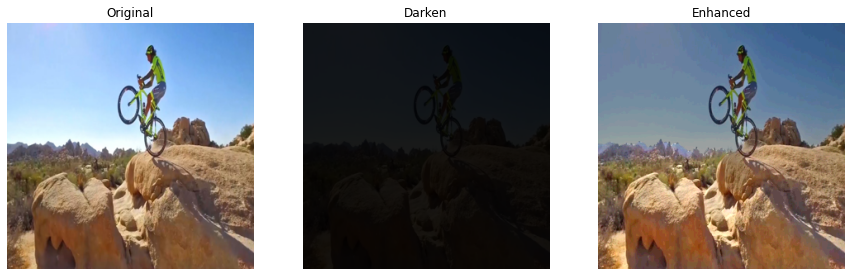

In [ ]:
image_sim_check('/content/drive/MyDrive/Data/test_data/bikestunt.jpg')

Image Similarity:- 0.9437774079288476


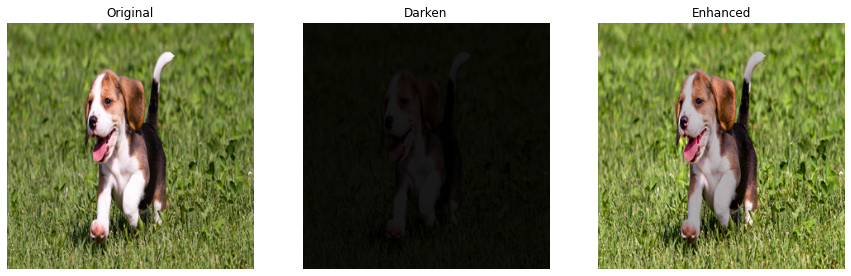

In [ ]:
image_sim_check('/content/drive/MyDrive/Data/test_data/image1.jpg')

Image Similarity:- 0.885784524280374


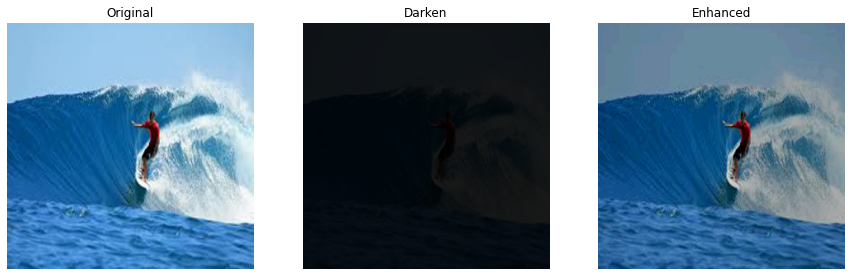

In [ ]:
image_sim_check('/content/drive/MyDrive/Data/test_data/surfing.jpeg')

#Object Detection


In [ ]:
%cd yolov3-tf2

/content/drive/.shortcut-targets-by-id/1OCqWIB1HkFVJkMAo4e6tMdDWvRFnQFMm/Data/yolov3-tf2


In [ ]:
!python convert.py

In [ ]:
import sys
from absl import app, logging, flags
from absl.flags import FLAGS
import time
from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny
)
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs
from IPython.display import Image, display

In [ ]:
flags.DEFINE_string('classes', './data/coco.names', 'path to classes file')
flags.DEFINE_string('weights', './checkpoints/yolov3.tf',
                    'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('image', './data/girl.png', 'path to input image')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_string('output', './output.jpg', 'path to output image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')

app._run_init(['yolov3'], app.parse_flags_with_usage)

['yolov3']

In [ ]:
if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)
      
yolo.load_weights(FLAGS.weights).expect_partial() # expect_partial just suppress some loading warning
logging.info('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')


I1214 03:41:00.597704 140673925490560 <ipython-input-26-92001a951765>:7] weights loaded
I1214 03:41:00.869966 140673925490560 <ipython-input-26-92001a951765>:10] classes loaded


In [ ]:
flickr_path = '/content/drive/MyDrive/Data/Flicker8k_Dataset/' # Kindly change path of dataset
paths2 = sorted(os.listdir(flickr_path))
print(len(paths2))

8091


In [ ]:
from PIL import Image
def reduce_enhance(path):
  im=Image.open(path)
  size=(299,299)
  im=im.resize(size)
  if(brightness(im)>90):
      out=reduce_brightness(im)
      image1=np.asarray(out)
      image2=np.array(im)
      enhanced_image = enhance_image_exposure(image1,0.8,0.2,3,1e-3)
  else:
      image2=np.asarray(im)
      image1=image2
      enhanced_image=image2
  return im,image1,enhanced_image

In [ ]:
def object_detection(path):
    from IPython.display import Image, display
    FLAGS.image = path
    x= open(FLAGS.image, 'rb').read()
    img_raw = tf.image.decode_image(x, channels=3)
    img = tf.expand_dims(img_raw, 0)
    img = transform_images(img, FLAGS.size)
    t1 = time.time()
    boxes, scores, classes, nums = yolo(img)
    t2 = time.time()
    for i in range(nums[0]):
        logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                        np.array(scores[0][i]),
                                        np.array(boxes[0][i])))

    img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
    img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

    display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=300))

In [ ]:
def enhance_object_detection(path):
  from PIL import Image
  original,darken,enhance=reduce_enhance(path)
  image1 = Image.fromarray(enhance)
  save_path='/content/drive/MyDrive/Data/enhanced/'+path.split('/')[-1]
  image1.save(save_path)
  from IPython.display import Image, display
  object_detection(save_path)
  plot_show(original,darken,enhance)
  os.remove(save_path)


I1214 03:41:10.296422 140673925490560 <ipython-input-29-5ae59563cbbf>:14] 	dog, 0.9971602559089661, [0.31920648 0.12780595 0.6887361  0.8684972 ]


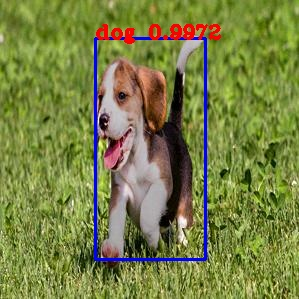

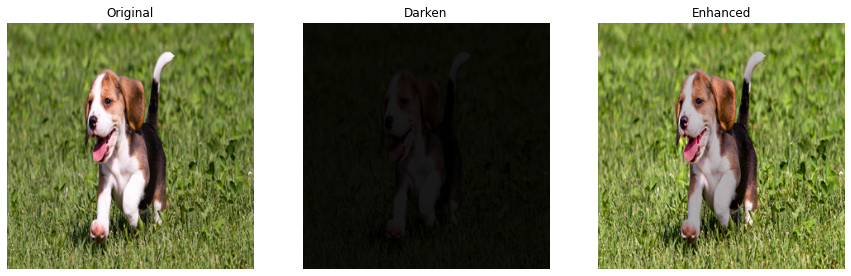

In [ ]:
enhance_object_detection('/content/drive/MyDrive/Data/test_data/image1.jpg')


I1214 03:41:10.954075 140673925490560 <ipython-input-29-5ae59563cbbf>:14] 	dog, 0.9968093633651733, [0.31220442 0.13703555 0.68186504 0.8811293 ]


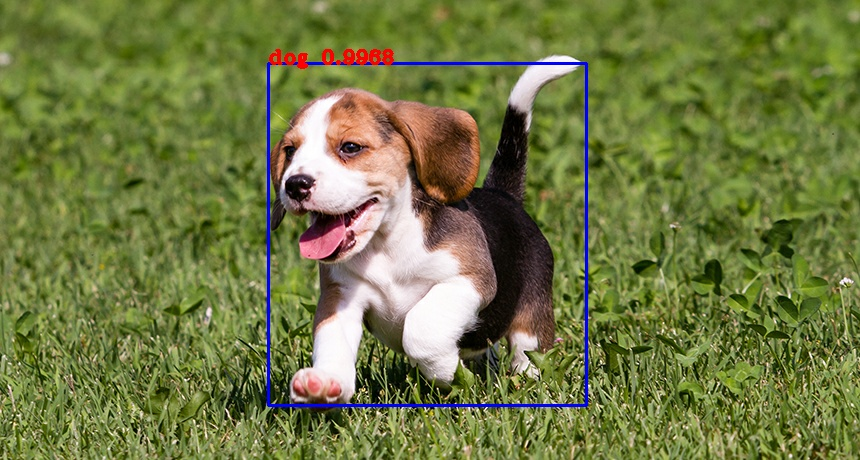

In [ ]:
object_detection('/content/drive/MyDrive/Data/test_data/image1.jpg')

I1214 03:41:14.179769 140673925490560 <ipython-input-29-5ae59563cbbf>:14] 	person, 0.9638929963111877, [0.5227741  0.40728587 0.67638075 0.7200995 ]
I1214 03:41:14.188672 140673925490560 <ipython-input-29-5ae59563cbbf>:14] 	person, 0.9208405017852783, [0.29938167 0.40618038 0.43490285 0.7932074 ]
I1214 03:41:14.196096 140673925490560 <ipython-input-29-5ae59563cbbf>:14] 	chair, 0.8652298450469971, [0.09544352 0.5102856  0.2542208  0.84824705]
I1214 03:41:14.204294 140673925490560 <ipython-input-29-5ae59563cbbf>:14] 	chair, 0.6284624934196472, [0.14703166 0.56919855 0.27643678 0.8470338 ]
I1214 03:41:14.211697 140673925490560 <ipython-input-29-5ae59563cbbf>:14] 	bench, 0.6127030253410339, [0.34448057 0.7573401  0.685546   0.9555663 ]


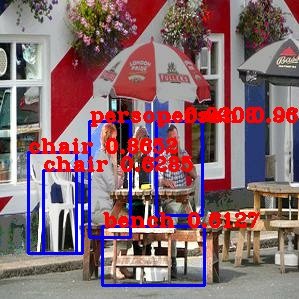

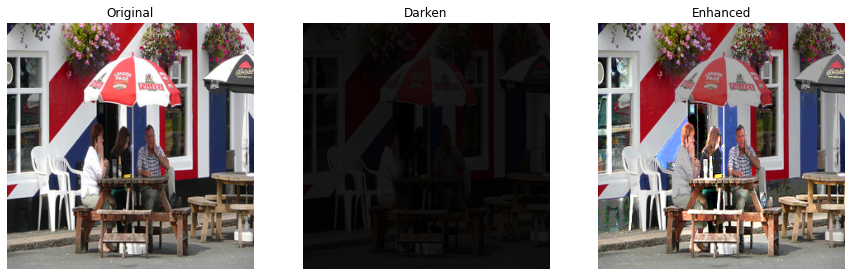

In [ ]:
enhance_object_detection('/content/drive/MyDrive/Data/Flicker8k_Dataset/1258913059_07c613f7ff.jpg')

I1214 03:41:14.853626 140673925490560 <ipython-input-29-5ae59563cbbf>:14] 	chair, 0.9704133868217468, [0.09572162 0.49563554 0.18919067 0.86075497]
I1214 03:41:14.862095 140673925490560 <ipython-input-29-5ae59563cbbf>:14] 	person, 0.952261745929718, [0.5219755  0.39824015 0.68380547 0.7933999 ]
I1214 03:41:14.869574 140673925490560 <ipython-input-29-5ae59563cbbf>:14] 	chair, 0.8843892216682434, [0.16173342 0.5624324  0.2678094  0.85024536]
I1214 03:41:14.877199 140673925490560 <ipython-input-29-5ae59563cbbf>:14] 	person, 0.8792826533317566, [0.29513127 0.42205775 0.4397906  0.84504426]
I1214 03:41:14.885261 140673925490560 <ipython-input-29-5ae59563cbbf>:14] 	bench, 0.7687589526176453, [0.3518191  0.75931835 0.6624363  0.96333766]


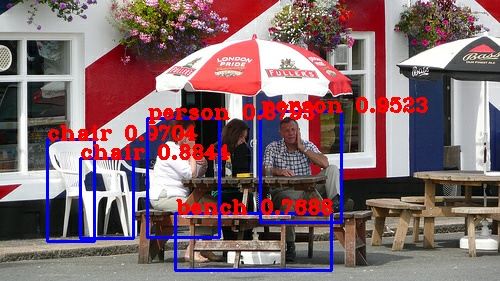

In [ ]:
object_detection("/content/drive/MyDrive/Data/Flicker8k_Dataset/1258913059_07c613f7ff.jpg")

I1214 03:41:17.813628 140673925490560 <ipython-input-29-5ae59563cbbf>:14] 	person, 0.9870559573173523, [0.46426916 0.59416556 0.7998682  0.9974501 ]
I1214 03:41:17.821572 140673925490560 <ipython-input-29-5ae59563cbbf>:14] 	frisbee, 0.9588439464569092, [0.45506266 0.4850518  0.5735505  0.567349  ]
I1214 03:41:17.828456 140673925490560 <ipython-input-29-5ae59563cbbf>:14] 	person, 0.9579702615737915, [0.11870201 0.7792281  0.5490057  0.99774194]
I1214 03:41:17.835461 140673925490560 <ipython-input-29-5ae59563cbbf>:14] 	person, 0.8902572989463806, [0.89606804 0.9268934  1.0016161  1.0009162 ]
I1214 03:41:17.842958 140673925490560 <ipython-input-29-5ae59563cbbf>:14] 	person, 0.6064057946205139, [0.8008524 0.9321014 0.9054376 0.9996602]
I1214 03:41:17.850538 140673925490560 <ipython-input-29-5ae59563cbbf>:14] 	person, 0.5195254683494568, [0.4137652  0.59938055 0.77567434 0.991829  ]
I1214 03:41:17.859871 140673925490560 <ipython-input-29-5ae59563cbbf>:14] 	person, 0.5031657814979553, [0.882

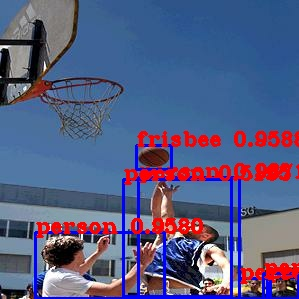

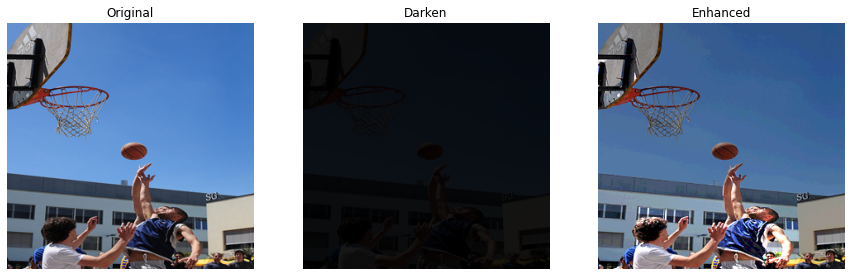

In [ ]:
enhance_object_detection("/content/drive/MyDrive/Data/Flicker8k_Dataset/3584561689_b6eb24dd70.jpg")

I1214 03:41:18.437538 140673925490560 <ipython-input-29-5ae59563cbbf>:14] 	person, 0.9962993264198303, [0.4321746  0.597298   0.76802754 0.9909544 ]
I1214 03:41:18.445708 140673925490560 <ipython-input-29-5ae59563cbbf>:14] 	person, 0.9553070664405823, [0.11451299 0.78293025 0.54644203 0.998556  ]
I1214 03:41:18.453048 140673925490560 <ipython-input-29-5ae59563cbbf>:14] 	person, 0.9437232613563538, [0.8868916  0.9171219  0.99686956 0.9981214 ]
I1214 03:41:18.460199 140673925490560 <ipython-input-29-5ae59563cbbf>:14] 	sports ball, 0.847741961479187, [0.45863262 0.48700634 0.5700415  0.55913097]
I1214 03:41:18.468858 140673925490560 <ipython-input-29-5ae59563cbbf>:14] 	person, 0.8099292516708374, [0.78510654 0.9370038  0.8983233  0.99736625]
I1214 03:41:18.477221 140673925490560 <ipython-input-29-5ae59563cbbf>:14] 	person, 0.6756252646446228, [0.06727922 0.9498707  0.13993779 1.0032897 ]


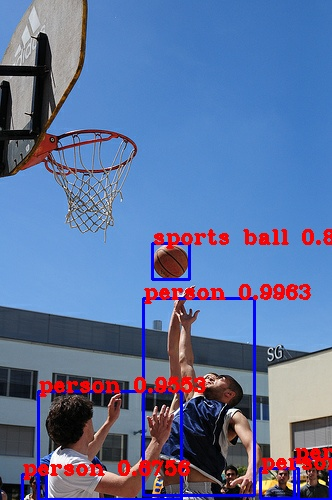

In [ ]:
object_detection("/content/drive/MyDrive/Data/Flicker8k_Dataset/3584561689_b6eb24dd70.jpg")

I1214 03:41:21.357298 140673925490560 <ipython-input-29-5ae59563cbbf>:14] 	person, 0.9994844198226929, [0.31557864 0.28273293 0.5131551  0.61724186]


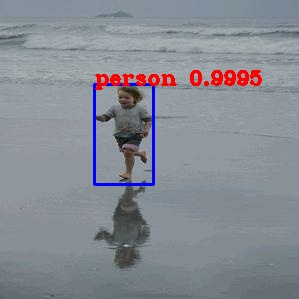

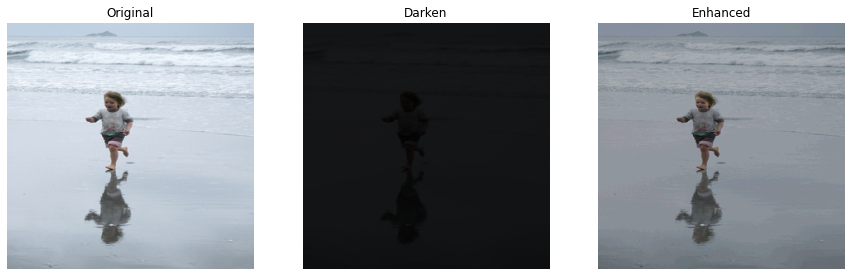

In [ ]:
enhance_object_detection("/content/drive/MyDrive/Data/Flicker8k_Dataset/3185409663_95f6b958d8.jpg")

I1214 03:41:21.944901 140673925490560 <ipython-input-29-5ae59563cbbf>:14] 	person, 0.9994530081748962, [0.31591263 0.28562558 0.5154501  0.6175602 ]


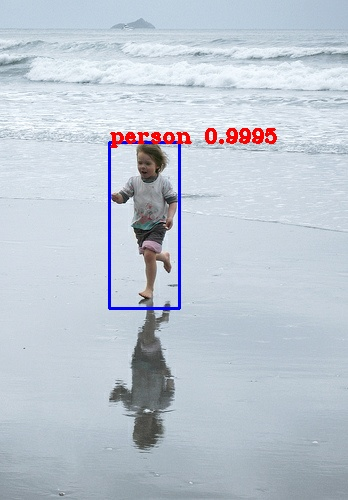

In [ ]:
object_detection("/content/drive/MyDrive/Data/Flicker8k_Dataset/3185409663_95f6b958d8.jpg")

# Attention Model

## Required Libraries

In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers import TextVectorization


seed = 111
np.random.seed(seed)
tf.random.set_seed(seed)

## Helpers

In [ ]:

# Path to the images
IMAGES_PATH = "/content/drive/MyDrive/Data/Flicker8k_Dataset"

# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 10000

# Fixed length allowed for any sequence
SEQ_LENGTH = 25

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters
BATCH_SIZE = 64
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:

def load_captions_data(filename):
    """Loads captions (text) data and maps them to corresponding images.

    Args:
        filename: Path to the text file containing caption data.

    Returns:
        caption_mapping: Dictionary mapping image names and the corresponding captions
        text_data: List containing all the available captions
    """

    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []
        images_to_skip = set()

        for line in caption_data:
            line = line.rstrip("\n")
            # Image name and captions are separated using a tab
            img_name, caption = line.split("\t")

            # Each image is repeated five times for the five different captions.
            # Each image name has a suffix `#(caption_number)`
            img_name = img_name.split("#")[0]
            img_name = os.path.join(IMAGES_PATH, img_name.strip())

            # We will remove caption that are either too short to too long
            tokens = caption.strip().split()

            if len(tokens) < 5 or len(tokens) > SEQ_LENGTH:
                images_to_skip.add(img_name)
                continue

            if img_name.endswith("jpg") and img_name not in images_to_skip:
                # We will add a start and an end token to each caption
                caption = "<start> " + caption.strip() + " <end>"
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]

        return caption_mapping, text_data


def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data


# Load the dataset
captions_mapping, text_data = load_captions_data("/content/drive/MyDrive/Data/Flickr8k.token.txt")

# Split the dataset into training and validation sets
train_data, valid_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Number of training samples:  6114
Number of validation samples:  1529


In [ ]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)


In [ ]:
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)

In [ ]:
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_input(img_path, captions):
    return decode_and_resize(img_path), vectorization(captions)


def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(len(images))
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset


# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))

valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))


## Defining and loading the model




In [ ]:
def get_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet",
    )
    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model

In [ ]:
class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

In [ ]:
class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

In [ ]:
class ImageCaptioningModel(keras.Model):
    def __init__(
        self, cnn_model, encoder, decoder, num_captions_per_image=5, image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)
        print("loss", self.loss_tracker.result())
        # 8. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]

In [ ]:
cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)

16719872/16705208 [==============================] - 1s 0us/step


In [ ]:
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


# Create a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

In [ ]:
model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)
model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)
model.train_step(list(train_dataset.as_numpy_iterator())[0])
model.built =True
model.load_weights('/content/drive/MyDrive/Capstone Project/CODE/model2.h5')

loss tf.Tensor(46.769806, shape=(), dtype=float32)


In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
import warnings
warnings.simplefilter('ignore')
from nltk.translate.bleu_score import sentence_bleu
np_config.enable_numpy_behavior()


vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())
valid_captions = list(valid_data.values())

In [ ]:
def reduce_enhance(path):
  im=Image.open(path)
  size=(299,299)
  im=im.resize(size)
  if(brightness(im)>90):
      out=reduce_brightness(im)
      image1=np.asarray(out)
      image2=np.array(im)
      enhanced_image = enhance_image_exposure(image1,0.8,0.2,3,1e-3)
  else:
      image2=np.asarray(im)
      image1=image2
      enhanced_image=image2
  return im,image1,enhanced_image

In [ ]:
def testing_2(path):
  sample_img = decode_and_resize(path)
  image = sample_img.numpy().clip(0, 255).astype(np.uint8)
  img = tf.expand_dims(sample_img, 0)
  img = model.cnn_model(img)
  encoded_img = model.encoder(img, training=False)
  decoded_caption = "<start> "
  for i in range(max_decoded_sentence_length):
    tokenized_caption = vectorization([decoded_caption])[:, :-1]
    mask = tf.math.not_equal(tokenized_caption, 0)
    predictions = model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
    sampled_token_index = np.argmax(predictions[0, i, :])
    sampled_token = index_lookup[sampled_token_index]
    if sampled_token == " <end>":
      break
    decoded_caption += " " + sampled_token

  decoded_caption = decoded_caption.replace("<start> ", "")
  decoded_caption = decoded_caption.replace(" <end>", "").strip()
  return image,decoded_caption

In [ ]:
def enhance_testing_2(path):
  original,darken,enhance=reduce_enhance(path)
  image1 = Image.fromarray(enhance)
  save_path='./enhanced/'+path.split('/')[-1]
  image1.save(save_path)
  img,caption=testing_2(save_path)
  os.remove(save_path)
  return img,caption


## Testing

In [ ]:
cd '/content/drive/MyDrive/Data/'

/content/drive/.shortcut-targets-by-id/1OCqWIB1HkFVJkMAo4e6tMdDWvRFnQFMm/Data


In [ ]:
testing_images_path='/content/drive/MyDrive/Data/Flicker8k_Dataset/'
import random
testing_images=[]
for i in range(50):
  random_filename = random.choice([x for x in os.listdir(testing_images_path)if os.path.isfile(os.path.join(testing_images_path, x))])
  testing_images.append(random_filename)

Individual 1-gram: 0.665045
Individual 2-gram: 0.358101
Individual 3-gram: 0.155177
Individual 4-gram: 0.931063
-------------------------------------------------------------


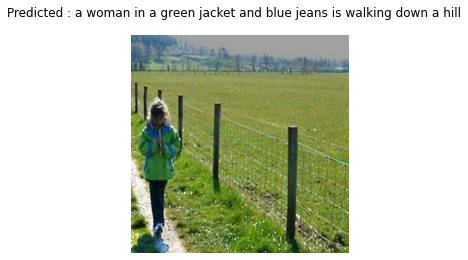

Individual 1-gram: 0.384615
Individual 2-gram: 0.166667
Individual 3-gram: 1.000000
Individual 4-gram: 1.000000
-------------------------------------------------------------


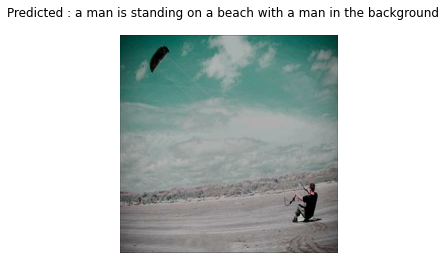

Individual 1-gram: 0.307692
Individual 2-gram: 0.083333
Individual 3-gram: 1.000000
Individual 4-gram: 1.000000
-------------------------------------------------------------


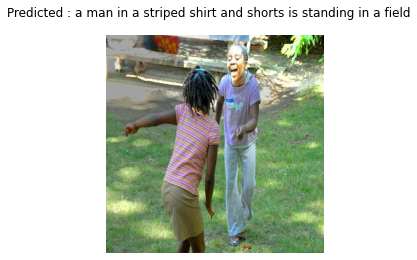

Individual 1-gram: 0.375000
Individual 2-gram: 1.000000
Individual 3-gram: 1.000000
Individual 4-gram: 1.000000
-------------------------------------------------------------


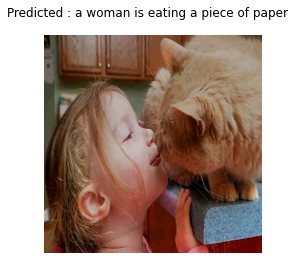

Individual 1-gram: 0.666667
Individual 2-gram: 0.250000
Individual 3-gram: 0.142857
Individual 4-gram: 1.000000
-------------------------------------------------------------


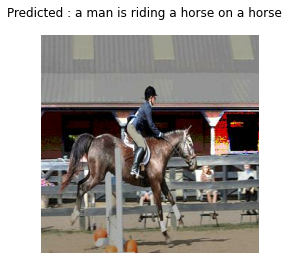

In [ ]:
for i in range(0,5):
  path='/content/drive/MyDrive/Data/Flicker8k_Dataset/'+testing_images[i]
  img,caption=enhance_testing_2(path)
  if path in valid_data.keys():
    actual = valid_data[path].copy()
  else:
    actual=train_data[path].copy()
  for i,j in enumerate(actual):
    j = j.replace("<start> ", "")
    j = j.replace(" . <end>", "").strip()
    j = j.split()
    actual[i] = j
  candidate = caption.split()
  #plt.figure(figsize=(10,5))
  plt.imshow(img)
  plt.suptitle('Predicted :'+' '+caption)
  plt.axis('off')
#     print('BLEU score -> {}'.format(sentence_bleu(captions, candidate)))
  print('Individual 1-gram: %f' % sentence_bleu(actual, candidate, weights=(1, 0, 0, 0)))
  print('Individual 2-gram: %f' % sentence_bleu(actual, candidate, weights=(0, 1, 0, 0)))
  print('Individual 3-gram: %f' % sentence_bleu(actual, candidate, weights=(0, 0, 1, 0)))
  print('Individual 4-gram: %f' % sentence_bleu(actual, candidate, weights=(0, 0, 0, 1)))
  print('-------------------------------------------------------------')
  plt.show()

  

Individual 1-gram: 0.625000
Individual 2-gram: 1.000000
Individual 3-gram: 1.000000
Individual 4-gram: 1.000000
-------------------------------------------------------------


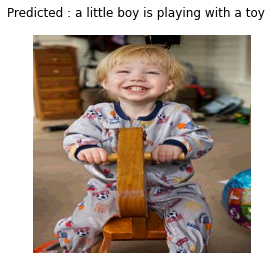

Individual 1-gram: 0.470588
Individual 2-gram: 0.375000
Individual 3-gram: 0.200000
Individual 4-gram: 0.071429
-------------------------------------------------------------


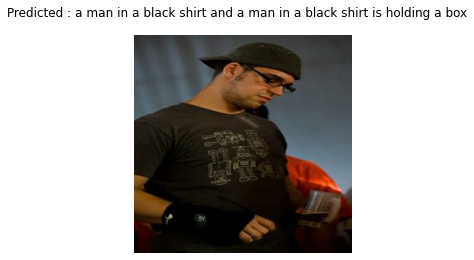

Individual 1-gram: 0.571429
Individual 2-gram: 0.230769
Individual 3-gram: 0.083333
Individual 4-gram: 1.000000
-------------------------------------------------------------


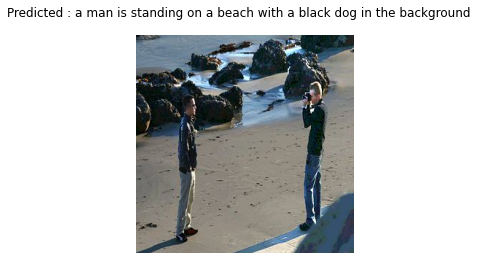

Individual 1-gram: 0.875000
Individual 2-gram: 0.857143
Individual 3-gram: 0.833333
Individual 4-gram: 0.800000
-------------------------------------------------------------


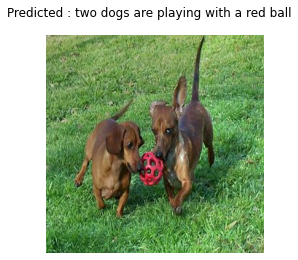

Individual 1-gram: 0.363636
Individual 2-gram: 0.200000
Individual 3-gram: 0.111111
Individual 4-gram: 1.000000
-------------------------------------------------------------


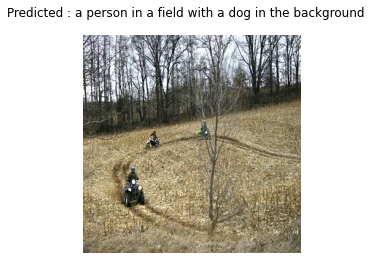

In [ ]:
for i in range(10,15):
  path='/content/drive/MyDrive/Data/Flicker8k_Dataset/'+testing_images[i]
  img,caption=enhance_testing_2(path)
  if path in valid_data.keys():
    actual = valid_data[path].copy()
  else:
    actual=train_data[path].copy()
  for i,j in enumerate(actual):
    j = j.replace("<start> ", "")
    j = j.replace(" . <end>", "").strip()
    j = j.split()
    actual[i] = j
  candidate = caption.split()
  #plt.figure(figsize=(10,5))
  plt.imshow(img)
  plt.suptitle('Predicted :'+' '+caption)
  plt.axis('off')
#     print('BLEU score -> {}'.format(sentence_bleu(captions, candidate)))
  print('Individual 1-gram: %f' % sentence_bleu(actual, candidate, weights=(1, 0, 0, 0)))
  print('Individual 2-gram: %f' % sentence_bleu(actual, candidate, weights=(0, 1, 0, 0)))
  print('Individual 3-gram: %f' % sentence_bleu(actual, candidate, weights=(0, 0, 1, 0)))
  print('Individual 4-gram: %f' % sentence_bleu(actual, candidate, weights=(0, 0, 0, 1)))
  print('-------------------------------------------------------------')
  plt.show()

  

a brown and white dog is running through a field of grass


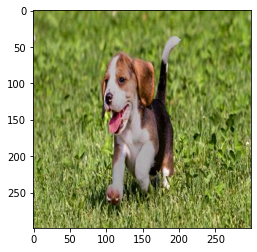

In [ ]:
img,caption=enhance_testing_2('/content/drive/MyDrive/Data/test_data/image1.jpg')
print(caption)
plt.imshow(img)
plt.show()

a man in a blue shirt is jumping off a basketball


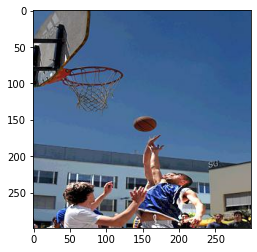

In [ ]:
img,caption=enhance_testing_2("/content/drive/MyDrive/Data/Flicker8k_Dataset/3584561689_b6eb24dd70.jpg")
print(caption)
plt.imshow(img)
plt.show()

a little boy is running on the beach


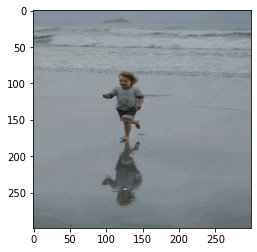

In [ ]:
img,caption=enhance_testing_2("/content/drive/MyDrive/Data/Flicker8k_Dataset/3185409663_95f6b958d8.jpg")
print(caption)
plt.imshow(img)
plt.show()

a man is on a bike jumping over a log


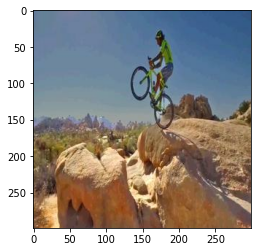

In [ ]:
img,caption=enhance_testing_2('/content/drive/MyDrive/Data/test_data/bikestunt.jpg')
print(caption)
plt.imshow(img)
plt.show()

a surfer is riding a wave over a wave


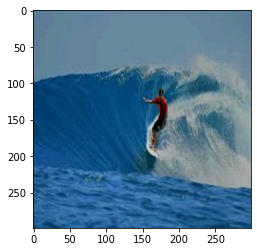

In [ ]:
img,caption=enhance_testing_2('/content/drive/MyDrive/Data/test_data/surfing.jpeg')
print(caption)
plt.imshow(img)
plt.show()